# Kaggle Fake News Detection

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # https://seaborn.pydata.org/
import nltk #Natural Language Toolkit https://www.nltk.org/
nltk.download("stopwords")  #downloading stopwords
nltk.download('punkt') #https://www.kite.com/python/docs/nltk.punkt
nltk.download('wordnet')
import re # regular expression libary. https://docs.python.org/3/library/re.html


from wordcloud import WordCloud, STOPWORDS # https://www.datacamp.com/community/tutorials/wordcloud-python
#pip install wordcloud or conda install -c conda-forge wordcloud


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Carolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Carolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Carolin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Imports for the project

## Loading the data

In [2]:
real_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')
articles= pd.read_csv('news_articles.csv')

snopes = pd.read_csv('snopes_phase1_clean_2018_7_3.csv')#Might not use it

In [3]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
real_data.count()

title      21417
text       21417
subject    21417
date       21417
dtype: int64

In [5]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake_data.count()

title      23481
text       23481
subject    23481
date       23481
dtype: int64

In [7]:
articles.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [8]:
articles['label'].value_counts()

Fake    1294
Real     801
Name: label, dtype: int64

## Processing the data

In [9]:
fake_data['label']='Fake' #Creating a new column which is called label and value in it is Fake
real_data['label']='Real'#Creating a new column which is called label and value in it is Real
#This is necessary if we want to concatenate the dataframes since we need a way to identify which articles are fake and which real.

In [10]:
articles.drop(['author','site_url','main_img_url','title_without_stopwords','hasImage','text_without_stopwords','language'],inplace=True,axis=1)

#Dropping unneccessary columns so we could concatenate it easier with our other two datasets

In [11]:
articles.isna().sum()#Checking how many NaN values exist

published     0
title         0
text         46
type          1
label         1
dtype: int64

In [12]:
articles = articles.dropna()#Dropping the rows with NaN values

In [13]:
articles.isna().sum()

published    0
title        0
text         0
type         0
label        0
dtype: int64

In [14]:
from dateutil.parser import parse
def is_valid_date(s): #Function to check whether date is valid or not
    try:
        parse(s)
        return True
    except:
        return False

articles = articles[articles.published.apply(is_valid_date)]#Leaving only the rows with valid dates.
articles['published'] = pd.to_datetime(articles['published'], utc=True)#Converting arguments in published column to datetime
articles['date']=articles['published'].dt.strftime("%d %B, %Y")#Creating a new column called date 
articles.drop('published',inplace=True,axis=1)

In [15]:
articles.rename(columns={'type': 'subject'}, inplace=True)#Changing the column name type to subject

In [16]:
columns = list(articles.columns)
columns[3],columns[4]=columns[4],columns[3] #Swapping the places of columns date and label
articles =articles[columns]

In [17]:
articles.head()

,title,text,subject,date,label
0,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,bias,"26 October, 2016",Real
1,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,bias,"29 October, 2016",Real
2,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,bias,"30 October, 2016",Real
3,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,bias,"01 November, 2016",Real
4,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,bias,"01 November, 2016",Real


#### Putting the dataframes together to make one unfied dataframe

In [18]:
news = pd.concat([real_data,fake_data,articles],ignore_index=True, sort=False) #Putting the dataframes all together into our new dataframe called news

In [19]:
news.isna().sum()#Checking if there are any NaN values

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [20]:
news.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real


In [21]:
news['label'].value_counts()

Fake    24772
Real    22174
Name: label, dtype: int64

Now we have put the data together from the first and second Kaggle dataset.

### Text to lower case

In [22]:
#news.title = news.title.str.lower()
#news.text = news.text.str.lower()

### Cleaning text from punctuations, numbers etc

In [23]:
def clean_text(text):
    clean_text = text
    clean_text = clean_text.lower() #text to lower case
    clean_text = re.sub('\[.*?\]', '', clean_text) # remove square brackets
    clean_text = re.sub(r'[^\w\s]','',clean_text) # remove punctuation
    clean_text = re.sub('\w*\d\w*', '', clean_text) # remove words containing numbers
    clean_text = re.sub(r'http\S+', '', clean_text) #removing links
    #clean_text = re.sub('\n', '', clean_text)
    return clean_text

### Removing stopwords and punctuation

In [24]:
news_copy = news.copy()
news['title_cleaned']=news_copy.title.apply(lambda text: clean_text(text))
news['text_cleaned']=news_copy.text.apply(lambda text: clean_text(text))
news.head()

,title,text,subject,date,label,title_cleaned,text_cleaned
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real,as us budget fight looms republicans flip thei...,washington reuters the head of a conservative...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real,us military to accept transgender recruits on ...,washington reuters transgender people will be...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real,senior us republican senator let mr mueller do...,washington reuters the special counsel invest...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real,fbi russia probe helped by australian diplomat...,washington reuters trump campaign adviser geo...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real,trump wants postal service to charge much more...,seattlewashington reuters president donald tr...


In [25]:
stopwords = nltk.corpus.stopwords.words("english")
def remove_stopwords(text):
    text_to_token = nltk.word_tokenize(text)
    remove_stopwords = [word for word in text_to_token if not word in stopwords]
    join_text = ' '.join(remove_stopwords)
    return join_text



In [26]:
news_copy = news.copy()
news['title_cleaned']=news_copy.title_cleaned.apply(lambda x : remove_stopwords(x))
news['text_cleaned']=news_copy.text_cleaned.apply(lambda x : remove_stopwords(x))
news.head()

,title,text,subject,date,label,title_cleaned,text_cleaned
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real,us budget fight looms republicans flip fiscal ...,washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real,us military accept transgender recruits monday...,washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real,senior us republican senator let mr mueller job,washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real,trump wants postal service charge much amazon ...,seattlewashington reuters president donald tru...


### Most words without lemmatization

In [27]:
fake_rows = news.loc[news['label'] == 'Fake']

fake_title_freq = pd.Series(' '.join(fake_rows.title_cleaned).split()).value_counts()
fake_title_dict = fake_title_freq.to_dict()

In [28]:
real_rows = news.loc[news['label'] == 'Real']

real_title_freq = pd.Series(' '.join(real_rows.title_cleaned).split()).value_counts()
real_title_dict = real_title_freq.to_dict()

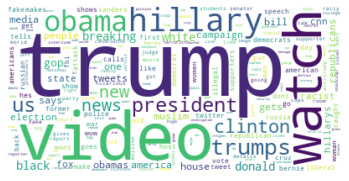

In [29]:
wordcloud_fake = WordCloud(background_color="white").generate_from_frequencies(fake_title_dict)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_fake.to_file("img/faketitles_without_lemma.png")

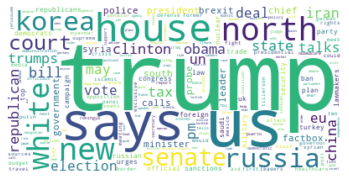

In [30]:
wordcloud_real = WordCloud(background_color="white").generate_from_frequencies(real_title_dict)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_real.to_file("img/realtitles_without_lemma.png")

### Most words after lemmatization

In [31]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemma_words(text):
    token_words=nltk.word_tokenize(text)
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(word.format(word,wordnet_lemmatizer.lemmatize(word, pos="v")))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

In [32]:
news['title_lemma']=news.title_cleaned.apply(lambda x : lemma_words(x))
news['text_lemma']=news.text_cleaned.apply(lambda x : lemma_words(x))

### Most used words in fake news articles' titles

In [33]:
fake_rows = news.loc[news['label'] == 'Fake']

fake_title_freq = pd.Series(' '.join(fake_rows.title_lemma).split()).value_counts()
fake_title_dict = fake_title_freq.to_dict()
fake_rows.head()

,title,text,subject,date,label,title_cleaned,text_cleaned,title_lemma,text_lemma
21417,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake,donald trump sends embarrassing new years eve ...,donald trump wish americans happy new year lea...,donald trump sends embarrassing new years eve ...,donald trump wish americans happy new year lea...
21418,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...
21419,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...
21420,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake,trump obsessed even obamas name coded website ...,christmas day donald trump announced would bac...,trump obsessed even obamas name coded website ...,christmas day donald trump announced would bac...
21421,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,pope francis called donald trump christmas spe...,pope francis used annual christmas day message...


### Most used words in real news' articles titles

In [34]:
real_rows = news.loc[news['label'] == 'Real']

real_title_freq = pd.Series(' '.join(real_rows.title_lemma).split()).value_counts()
real_title_dict = real_title_freq.to_dict()


### Wordcloud

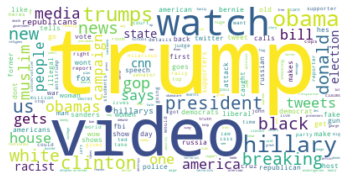

In [35]:
wordcloud_fake = WordCloud(background_color="white").generate_from_frequencies(fake_title_dict)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_fake.to_file("img/faketitles_review.png")

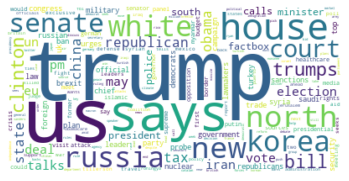

In [36]:
wordcloud_real = WordCloud(background_color="white").generate_from_frequencies(real_title_dict)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_real.to_file("img/realtitles_review.png")

# Training Models

### Vectorizing with CountVectorizer
To use Descision Tree and Random Forest classifiers we need to convert text data into numerical data.
CountVectorizer converts a collection of text documents to matrix of token counts. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html.

We will take 10000 instances of fake and real news articles to train our first models. Unfortunately couldn't go over that number since then we run into memory errors. We will also create a validation set for checking how well the models predict.

In [37]:
fake_rows = news.loc[news['label'] == 'Fake']
real_rows = news.loc[news['label'] == 'Real']
news_for_modeling1=pd.concat([fake_rows[:10000],real_rows[:10000]],ignore_index=True, sort=False) 

news_for_validation = pd.concat([fake_rows[10000:20000],real_rows[10000:20000]],ignore_index=True, sort=False) 

In [38]:
X=news_for_modeling1[['text_lemma', 'title_lemma']]
y=news_for_modeling1['label']    

X_val =news_for_validation[['text_lemma', 'title_lemma']]
y_val =news_for_validation['label']

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
CountVec = CountVectorizer(max_features=5000)
News_text = CountVec.fit_transform(X['text_lemma']).todense()

News_text

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [40]:
News_title = CountVec.fit_transform(X['title_lemma']).todense()

News_title

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
news_text_val=CountVec.fit_transform(X_val['text_lemma']).todense()

In [42]:
news_title_val= CountVec.fit_transform(X_val['title_lemma']).todense()

#### Stacking the arrays column wise.
Putting the text and title vectorized versions together
https://numpy.org/doc/stable/reference/generated/numpy.hstack.html

In [43]:
X_mat = np.hstack(( News_text, News_title)) #Matrix for splitting into train and test sets

In [44]:
X_matrix_val=np.hstack(( news_text_val, news_title_val)) #Matrix for the validation set

### Decision Tree Classsifier

In [45]:
from sklearn.model_selection import train_test_split
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(X_mat,y, test_size=0.4, random_state=42)

In [46]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc_model=dtc.fit(X_train_dtc,  y_train_dtc)
y_pred_dtc=dtc_model.predict(X_test_dtc)

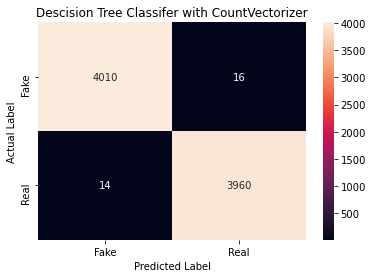

In [47]:
from sklearn.metrics import confusion_matrix
con_mat=confusion_matrix(y_test_dtc, y_pred_dtc)
sns.heatmap(con_mat,annot=True,linecolor="white",fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.title("Descision Tree Classifer with CountVectorizer")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [48]:
from sklearn.metrics import accuracy_score
dtc1_acc=accuracy_score(y_test_dtc, y_pred_dtc)
print("Model Accuracy: "+str(dtc1_acc))

Model Accuracy: 0.99625


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test_dtc, y_pred_dtc, digits=4))

              precision    recall  f1-score   support

        Fake     0.9965    0.9960    0.9963      4026
        Real     0.9960    0.9965    0.9962      3974

    accuracy                         0.9962      8000
   macro avg     0.9962    0.9963    0.9962      8000
weighted avg     0.9963    0.9962    0.9963      8000



In [50]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, train_support = score(y_test_dtc, y_pred_dtc, pos_label='Real', average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(accuracy_score(y_test_dtc, y_pred_dtc), 3)))


model1=[round(precision, 3),round(recall, 3), round(fscore,3),round(accuracy_score(y_test_dtc, y_pred_dtc), 3)]

Precision: 0.996 / Recall: 0.996 / F1-Score: 0.996 / Accuracy: 0.996


#### Checking how well the model predicts the labels for our validation set

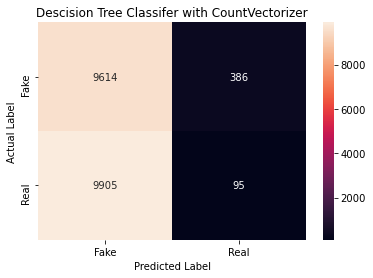

Model Accuracy: 0.48545


In [51]:
y_val_test=dtc_model.predict(X_matrix_val)
con_mat=confusion_matrix(y_val, y_val_test)
sns.heatmap(con_mat,annot=True,linecolor="white",fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.title("Descision Tree Classifer with CountVectorizer")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()
dtc_val_acc=accuracy_score(y_val, y_val_test)
print("Model Accuracy: "+ str(dtc_val_acc))

In [52]:
precision, recall, fscore, train_support = score(y_val, y_val_test, pos_label='Real', average='binary')

model1_val=[round(precision, 3),round(recall, 3), round(fscore,3),round(accuracy_score(y_val, y_val_test), 3)]

### Random Forest Classifier

In [53]:
from sklearn.model_selection import train_test_split
X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = train_test_split(X_mat,y, test_size=0.4, random_state=42)

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rfc_model=rf.fit(X_train_rfc,y_train_rfc)
y_pred_rfc = rfc_model.predict(X_test_rfc)


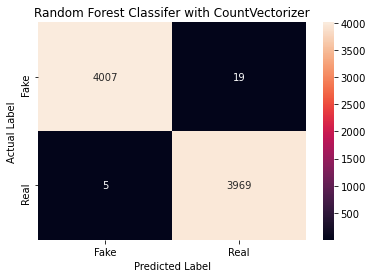

In [55]:
con_mat=confusion_matrix(y_test_rfc, y_pred_rfc)
sns.heatmap(con_mat,annot=True,linecolor="white",fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.title("Random Forest Classifer with CountVectorizer")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [56]:
accuracy_score(y_test_rfc,y_pred_rfc)

0.997

In [57]:
print(classification_report(y_test_rfc,y_pred_rfc, digits=4))

              precision    recall  f1-score   support

        Fake     0.9988    0.9953    0.9970      4026
        Real     0.9952    0.9987    0.9970      3974

    accuracy                         0.9970      8000
   macro avg     0.9970    0.9970    0.9970      8000
weighted avg     0.9970    0.9970    0.9970      8000



In [58]:
precision, recall, fscore, train_support = score(y_test_rfc,y_pred_rfc, pos_label='Real', average='binary')

model2=[round(precision, 3),round(recall, 3), round(fscore,3),round(accuracy_score(y_test_rfc,y_pred_rfc), 3)]

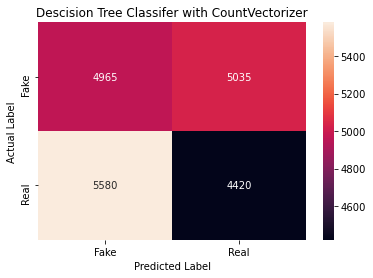

0.46925


In [59]:
y_test=rfc_model.predict(X_matrix_val)
con_mat=confusion_matrix(y_val, y_test)
sns.heatmap(con_mat,annot=True,linecolor="white",fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.title("Descision Tree Classifer with CountVectorizer")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

print(accuracy_score(y_val, y_test))

In [60]:
precision, recall, fscore, train_support = score(y_val, y_test, pos_label='Real', average='binary')

model2_val=[round(precision, 3),round(recall, 3), round(fscore,3),round(accuracy_score(y_val, y_test), 3)]



### Vectorising with TfidfVectorizer


We will take 3000 of real and 3000 of fake news instances for vectorising and training so we won't run out of memory.

In [61]:

fake_rows = news.loc[news['label'] == 'Fake']
real_rows = news.loc[news['label'] == 'Real']
news_for_modeling=pd.concat([fake_rows[:3000],real_rows[:3000]],ignore_index=True, sort=False) 
news_for_validation = pd.concat([fake_rows[3000:6000],real_rows[3000:6000]],ignore_index=True, sort=False) 

In [62]:

X=news_for_modeling[['text_lemma', 'title_lemma']]
y=news_for_modeling['label']    

X_val =news_for_validation[['text_lemma', 'title_lemma']]
y_val =news_for_validation['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vect = TfidfVectorizer()
vect_fit =tfidf_vect.fit(X_train['text_lemma'])
vect_fit_title=tfidf_vect.fit(X_train['title_lemma'])

tfidf_train = vect_fit.transform(X_train['text_lemma'])
tfidf_test = vect_fit.transform(X_test['text_lemma'])

tfidf_train_title = vect_fit_title.transform(X_train['title_lemma'])
tfidf_test_title = vect_fit_title.transform(X_test['title_lemma'])

tfidf_val=vect_fit.transform(X_val['text_lemma'])
tfidf_val_title=vect_fit_title.transform(X_val['title_lemma'])

X_train_vect = pd.concat([pd.DataFrame(tfidf_train.toarray()),pd.DataFrame(tfidf_train_title.toarray())], axis=1)
X_test_vect =pd.concat([pd.DataFrame(tfidf_test.toarray()),pd.DataFrame(tfidf_test_title.toarray())], axis=1)
X_val_vect =pd.concat([pd.DataFrame(tfidf_val.toarray()),pd.DataFrame(tfidf_val_title.toarray())], axis=1)
X_train_vect.head()

,0,1,2,3,4,5,6,7,8,9,...,6386,6387,6388,6389,6390,6391,6392,6393,6394,6395
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400298,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.060025,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Random Forest Classifier

In [64]:
rf = RandomForestClassifier()

rf_model = rf.fit(X_train_vect, y_train)

y_pred = rf_model.predict(X_test_vect)

accuracy_score(y_test,y_pred)

0.9983333333333333

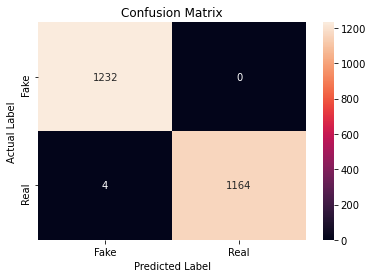

In [65]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [66]:
precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='Real', average='binary')

model3=[round(precision, 3),round(recall, 3), round(fscore,3),round(accuracy_score(y_test, y_pred), 3)]

0.9978333333333333


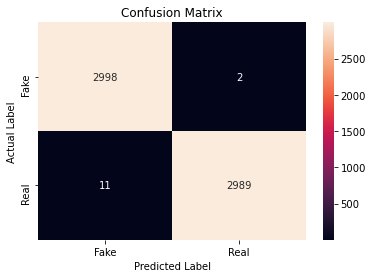

In [67]:
y_val_pred=rf_model.predict(X_val_vect)
print(accuracy_score(y_val,y_val_pred))
cm = confusion_matrix(y_val,y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [68]:
precision, recall, fscore, train_support = score(y_val,y_val_pred, pos_label='Real', average='binary')

model3_val=[round(precision, 3),round(recall, 3), round(fscore,3),round(accuracy_score(y_val,y_val_pred), 3)]

### Descision Tree Classifier

In [69]:
descision_tree = DecisionTreeClassifier(criterion='entropy')
descision_tree_model=descision_tree.fit(X_train_vect, y_train)
y_pred=descision_tree_model.predict(X_test_vect)

accuracy_score(y_test,y_pred)

0.9979166666666667

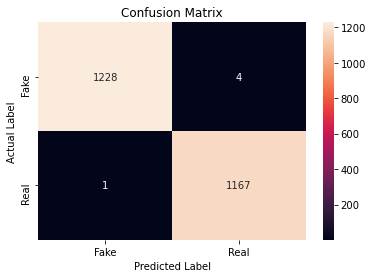

In [70]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [71]:
precision, recall, fscore, train_support = score(y_val,y_val_pred, pos_label='Real', average='binary')

model4=[round(precision, 3),round(recall, 3), round(fscore,3),round(accuracy_score(y_val,y_val_pred), 3)]

0.9975


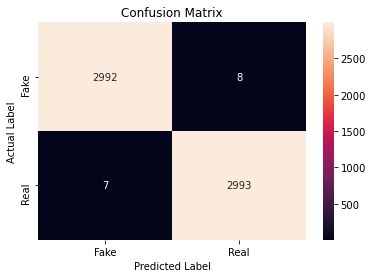

In [72]:
y_val_pred=descision_tree_model.predict(X_val_vect)
print(accuracy_score(y_val,y_val_pred))
cm = confusion_matrix(y_val,y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [73]:
precision, recall, fscore, train_support = score(y_val,y_val_pred, pos_label='Real', average='binary')

model4_val=[round(precision, 3),round(recall, 3), round(fscore,3),round(accuracy_score(y_val,y_val_pred), 3)]

## Comparing the models

In [74]:
models =[model1,model1_val,model2,model2_val,model3,model3_val,model4,model4_val]

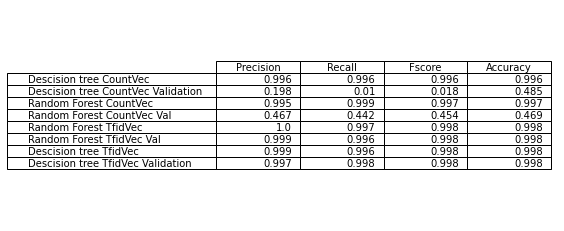

In [75]:

columns = ['Precision', 'Recall', 'Fscore', 'Accuracy']
rows = ['Descision tree CountVec', 'Descision tree CountVec Validation', 'Random Forest CountVec','Random Forest CountVec Val', 'Random Forest TfidVec','Random Forest TfidVec Val', 'Descision tree TfidVec', 'Descision tree TfidVec Validation']



cell_text = models
row_labels = rows
col_labels = columns

ytable = plt.table(cellText=cell_text, rowLabels=row_labels, colLabels=col_labels, loc="center right")
plt.axis("off")
plt.grid(False)
plt.show()


### Categories

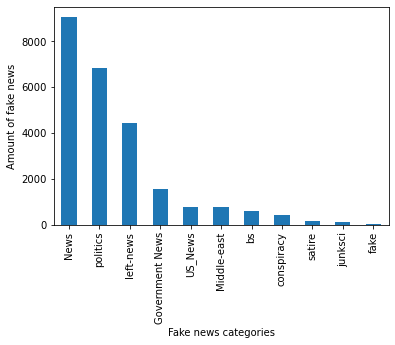

In [111]:
for_barplot = fake_rows.subject.value_counts()
plot = for_barplot.plot(kind='bar')
plot.set_xlabel("Fake news categories")
plot.set_ylabel("Amount of fake news")

plot.get_figure().savefig('fakeCategories.png', dpi = 500, bbox_inches='tight') 

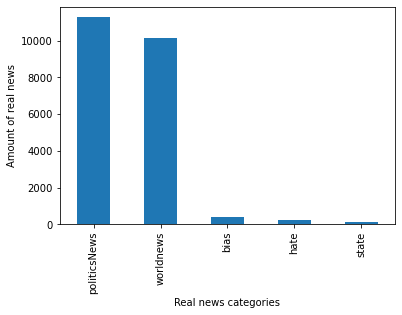

In [110]:
for_barplot_real = real_rows.subject.value_counts()

realnews_plot = for_barplot_real.plot(kind='bar')
realnews_plot.set_xlabel("Real news categories")
realnews_plot.set_ylabel("Amount of real news")

realnews_plot.get_figure().savefig('realCategories.png', dpi = 500, bbox_inches='tight')